<a href="https://colab.research.google.com/github/nicolesaade/WorldHappinessReportAnalysis/blob/main/WorldHappinessReport_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Predict 2023 Life Ladder

##3(a) Load Life Ladder Score



In [32]:
import statsmodels.api as sm
import pandas as pd
# Load the data
data = pd.read_excel('happiness_dataset.xls') #where's 2024 data? we tried predicting 2023 here

#Dataframe with ladder score from 2008 to 2022
ladder_df = data[['Country name', 'year', 'Life Ladder']].loc[data['year']!=2023]

#Dataframe with true ladder score
ladder_2023 = data.loc[data['year']==2023][['Country name', 'Life Ladder']]

be_removed = ['Cuba', 'Guyana', 'Maldives', 'Oman', 'Suriname']
#Remove countries with ladder score for only one year
ladder_df = ladder_df.loc[~ladder_df['Country name'].isin(be_removed)]
ladder_2023 = ladder_2023.loc[~ladder_2023['Country name'].isin(be_removed)]

#Remove countries with missing 2023 true ladder score
ladder_df = ladder_df.loc[ladder_df['Country name'].isin(ladder_2023['Country name'].unique())]

ladder_df.head()

,Country name,year,Life Ladder
0,Afghanistan,2008,3.723590
1,Afghanistan,2009,4.401778
2,Afghanistan,2010,4.758381
3,Afghanistan,2011,3.831719
4,Afghanistan,2012,3.782938


##3(b) Predict 2023 Life Ladder Score for each country

###3(b) 1. Linear Regresion

In [33]:
from sklearn.linear_model import LinearRegression

def predict_LinReg(country_name):
  df = ladder_df.loc[ladder_df['Country name']==country_name]
  X = df.loc[:, 'year'].values.reshape(-1, 1)
  y = df.loc[:, 'Life Ladder']
  model = LinearRegression().fit(X, y)
  y_pred = model.predict([[2023]])

  return y_pred[0]

LinReg_2023_pred = []

for country in ladder_df['Country name'].unique():
  if country not in be_removed:
    LinReg_2023_pred.append([predict_LinReg(country)][0])

ladder_2023['Linear Regression'] = LinReg_2023_pred

ladder_2023.head()

,Country name,Life Ladder,Linear Regression
14,Afghanistan,1.445909,1.835918
30,Albania,5.444691,5.005048
63,Argentina,6.393229,6.098444
80,Armenia,5.679090,5.148531
97,Australia,7.024582,7.123431


###3(b) 2. Lagged Features

In [34]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

def predict_ladder(country_name):
  df = ladder_df.loc[ladder_df['Country name']==country_name]
  ladder = df['Life Ladder']
  lagged_df = pd.concat(
       [ladder,
        ladder.shift(1).rename("lagged_2008"),
        ladder.shift(2).rename("lagged_2009"),
        ladder.shift(3).rename("lagged_2010"),
        ladder.shift(4).rename("lagged_2011"),
        ladder.shift(5).rename("lagged_2012"),
        ladder.shift(6).rename("lagged_2013"),
        ladder.shift(7).rename("lagged_2014"),
        ladder.shift(8).rename("lagged_2015"),
        ladder.shift(9).rename("lagged_2016"),
        ladder.shift(10).rename("lagged_2017"),
        ladder.shift(11).rename("lagged_2018"),
        ladder.shift(12).rename("lagged_2019"),
        ladder.shift(13).rename("lagged_2020"),
        ladder.shift(14).rename("lagged_2021"),
        ladder.shift(15).rename("lagged_2022")],
    axis="columns",)
  #lagged_df.tail()

  X = lagged_df.drop('Life Ladder', axis="columns")
  y = lagged_df['Life Ladder']
  #print("X shape: {}\ny shape: {}".format(X.shape, y.shape))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = HistGradientBoostingRegressor().fit(X_train, y_train)
  y_pred = model.predict(X_test)

  return y_pred[0]

In [36]:
ladder_2023_pred = []

for country in ladder_df['Country name'].unique():
  if country not in be_removed:
    ladder_2023_pred.append([predict_ladder(country)][0])

ladder_2023['Lagged'] = ladder_2023_pred

ladder_2023.head()

,Country name,Life Ladder,Linear Regression,Lagged
14,Afghanistan,1.445909,1.835918,3.462949
30,Albania,5.444691,5.005048,5.120927
63,Argentina,6.393229,6.098444,6.288584
80,Armenia,5.679090,5.148531,4.595113
97,Australia,7.024582,7.123431,7.263448


##3(c) Display Results

Text(0, 0.5, 'Predicted (Lagged Features)')

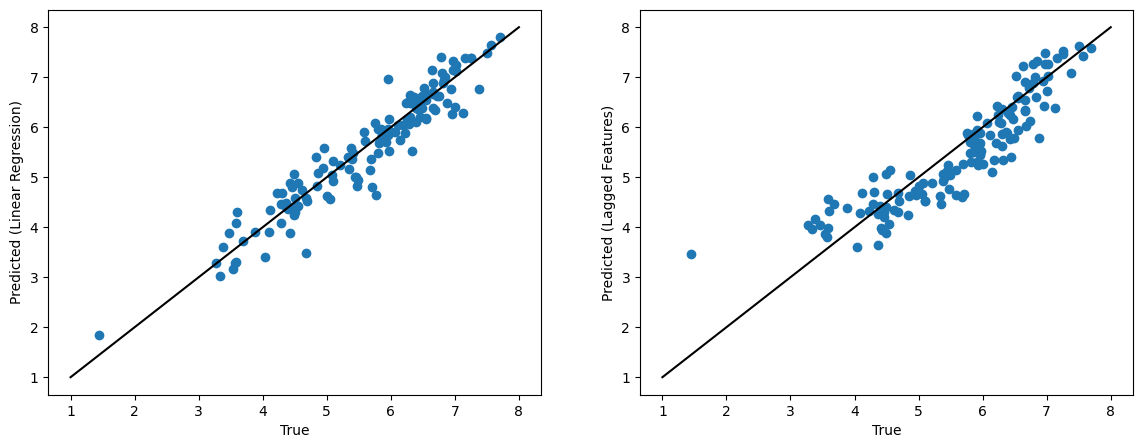

In [49]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, figsize=(14,5))

axs[0].scatter(ladder_2023['Life Ladder'], ladder_2023['Linear Regression'])
x = np.linspace(1, 8, 400)
axs[0].plot(x, x, c='k')
axs[0].set_xlabel('True')
axs[0].set_ylabel('Predicted (Linear Regression)')

axs[1].scatter(ladder_2023['Life Ladder'], ladder_2023['Lagged'])
axs[1].plot(x, x, c='k')
axs[1].set_xlabel('True')
axs[1].set_ylabel('Predicted (Lagged Features)')